# Perturbation: Neoclassical Growth Model

__Warm-up: install the `ForwardDiff` library. Use it to differentiate the function below. Check the jacobian function.__

Note: the signature of function `f` needs to be fixed first to allow for dual numbers as arguments.

In [1]:
function f(x::Vector{Float64})::Vector{Float64}
    a = x[1]
    b = x[2]
    x1 = a+
    b
    x2 = a*exp(b)
    return [x1,x2]
end

f (generic function with 1 method)

__Create a NamedTuple to hold the model parameters.__

In [2]:
p = (;α=0.3, β=0.96, γ=4.0, δ=0.1, ρ=0.9)

(α = 0.3, β = 0.96, γ = 4.0, δ = 0.1, ρ = 0.9)

__Define two functions:__
- `transition(z::Number, k::Number, i::Number, p)::Tuple{Float64}` which returns productivity and capital at date `t+1` as a function of productivity, capital and investment at date `t`
- `arbitrage(z::Number, k::Number, i::Number, Z::Number, K::Number, I::Number, p)::Float64` which returns the residual of the euler equation (lower case variable for date t, upper case for date t+1)


In [3]:
function transition(z::Number, k::Number, i::Number, p)
    (;α, β, γ, δ, ρ) = p
    # equivalent to
    # α=p.α
    # ...
    Z = ρ*z
    K = (1-δ)*k + i
    return (Z,K)
end

transition (generic function with 1 method)

In [4]:
function arbitrage(z::Number, k::Number, i::Number, Z::Number, K::Number, I::Number,p)
    (;α, β, γ, δ, ρ) = p
    y = exp(z)*k^α
    Y = exp(Z)*K^α
    c = y - i
    C = Y - I
    r  = β*(C/c)^(-γ)*(1-δ+α*K^(α-1)*exp(Z)) - 1
    return (r, )
end

arbitrage (generic function with 1 method)

__Using multiple dispatch, define two variants of the same functions, that take vectors as input and output arguments:__
- `arbitrage(s::Vector{T}, x::Vector{T}, S::Vector{T}, X::Vector{T}, p) where T<:Number`
- `transition(s::Vector{T}, x::Vector{T}, p) where T<:Number`

In [5]:
function arbitrage(s::Vector{<:Number}, x::Vector{<:Number}, S::Vector{<:Number}, X::Vector{<:Number}, p)
    
    z,k = s
    i, = x
    Z,K = S
    I, = X
    (r,) = arbitrage(z,k,i,Z,K,I, p)
    return [r]

end

arbitrage (generic function with 2 methods)

In [6]:
function transition(s::Vector{<:Number}, x::Vector{<:Number}, p)
    
    z,k = s
    i, = x
    Z,K = transition(z,k,i, p)
    return [Z,K]

end

transition (generic function with 2 methods)

__Write a function `steady_state(p)::Tuple{Vector,Vector}` which computes the steady-state of the model computed by hand.__
It returns two vectors, one for the states, one for the controls. Check that the steady-state satisfies the model equations.


In [7]:
# traditional unpacking
f(n) = (n^2, n)
t1,t2 = f(34)

(1156, 34)

In [8]:
# unpacking with "slurp"
g(n) = (n^2, n, n-5, n-3)
t1,t2,tr... = g(34)

tr


# t1,tm...,tl = g(34)


(29, 31)

In [9]:
# unpack with names for any structure:

struct Example
    a
    b
end

ex = Example(0.1, 0.5)

a = ex.a
b = ex.b

# a,b = ex[1], ex[2]
(;a,b) = ex


Example(0.1, 0.5)

In [10]:
function steady_state(p)
    (;α, β, γ, δ, ρ) = p
    k = ((1/β-(1-δ))/α)^(1/(α-1))
    i = k*δ
    z = 0
    return (;s=[z,k], x=[i])
end

steady_state (generic function with 1 method)

In [11]:
ss = steady_state(p)

(s = [0.0, 2.920822149964071], x = [0.29208221499640713])

In [12]:
transition(ss.s,ss.x,p) - ss.s

2-element Vector{Float64}:
 0.0
 0.0

In [13]:
arbitrage(ss.s, ss.x, ss.s, ss.x, p)

1-element Vector{Float64}:
 0.0

The first order system satisfies:
$$\begin{align}A s_t + B x_t + C s_{t+1} + D x_{t+1} & = & 0 \\\\ 
s_{t+1} & = & E s_t + F x_t
 \end{align}$$

__Define a structure `PerturbedModel` to hold matrices A,B,C,D,E,F.__



In [14]:
struct PerturbedModel
    A::Matrix{Float64}
    B::Matrix{Float64}
    C::Matrix{Float64}
    D::Matrix{Float64}
    E::Matrix{Float64}
    F::Matrix{Float64}
end

__Write a function `first_order_model(s::Vector, x::Vector, p)::PerturbedModel`, which returns the first order model, given the steady-state and the calibration. Suggestion: use `ForwardDiff.jl` library.__

In [15]:
using ForwardDiff

function first_order_model(ss, p)
    A  = ForwardDiff.jacobian(u->arbitrage(u, ss.x, ss.s, ss.x, p), ss.s)
    B  = ForwardDiff.jacobian(u->arbitrage(ss.s, u, ss.s, ss.x, p), ss.x)
    C  = ForwardDiff.jacobian(u->arbitrage(ss.s, ss.x, u, ss.x, p), ss.s)
    D  = ForwardDiff.jacobian(u->arbitrage(ss.s, ss.x, ss.s, u, p), ss.x)

    E  = ForwardDiff.jacobian(u->transition(u, ss.x, p), ss.s)
    F  = ForwardDiff.jacobian(u->transition(ss.s, u, p), ss.x)
    PerturbedModel(A,B,C,D,E,F)
end

first_order_model (generic function with 1 method)

In [16]:
first_order_model(ss, p )

PerturbedModel([5.074626865671642 0.5212190203776081], [-3.679193085018409;;], [-4.938626865671642 -0.5538125831185546], [3.679193085018409;;], [0.9 0.0; 0.0 0.9], [0.0; 1.0;;])

In [17]:
first_order_model(p) = first_order_model(steady_state(p), p)

first_order_model (generic function with 2 methods)

In [18]:
m = first_order_model(p)

PerturbedModel([5.074626865671642 0.5212190203776081], [-3.679193085018409;;], [-4.938626865671642 -0.5538125831185546], [3.679193085018409;;], [0.9 0.0; 0.0 0.9], [0.0; 1.0;;])

__We look for a linear solution $x_t = X s_t$ . Write the matrix equation which `X` must satisfy. Write a function `residual(X::Array, M::PerturbedModel)` which computes the residual of this equation for a given `X`.__


In [19]:
# cf course

__Write a function `T(X, M::PerturbedModel)`  which implements the time iteration step.__

In [19]:
X0 = rand(length(ss.x), length(ss.s))


function T(X, M)

    (;A,B,C,D,E,F) = M

    Xn = -(B + (C+D*X)*F) \ (A + (C+D*X)*E)

    return Xn
end


function F(X, M)
    (;A,B,C,D,E,F) = M
    return (A+B*X) + (C+D*X)*(E+F*X)
end


F (generic function with 1 method)

In [20]:
T(X0, m)

1×2 Matrix{Float64}:
 1.24534  0.735909

__Write function `linear_time_iteration(X_0::Matrix, m::PerturbedModel)::Matrix` which implements the time iteration algorithm. Apply it to `X0 = rand(1,2)` and check that the result satisfies the first order model.__

    

In [21]:
using LinearAlgebra: norm


In [22]:
maximum(abs, (X1-X2))

UndefVarError: UndefVarError: X1 not defined

In [23]:

distance(M1, M2) = maximum(abs(u-v) for (u,v) in zip(M1, M2))

distance (generic function with 1 method)

In [24]:
@time norm(X1-X2)
@time distance(X1,X2)
@time maximum(abs, (X1-X2))

UndefVarError: UndefVarError: X1 not defined

In [25]:
function linear_time_iteration(X, M; K=1000, τ_η=1e-8, log=true, verbose=true)

    if log
        history=[]
    end

    
    η0 = 1.0
    X_0 = copy(X)
    for t=1:K
        X = T(X_0, M)
        η = distance(X, X_0)
        if log
            push!(history, η)
        end
        λ = η/η0
        ϵ = norm(F(X, M))
        η0 = η
        if verbose
            @show (t,ϵ,η, λ) 
        end
        # println("t,η", t, v)
        if η<τ_η
            if log
                return (;X, history)
            else
                return (;X, )
            end
        end
        X_0 = X
    end
end

linear_time_iteration (generic function with 1 method)

In [26]:
X0 = rand(1,2)
result = linear_time_iteration(X0, m; log=true, verbose=true)

(t, ϵ, η, λ) = (1, 0.12555777998304188, 0.036111691164794624, 0.036111691164794624)
(t, ϵ, η, λ) = (2, 0.10442518445907749, 0.03000824785808809, 0.8309842848717981)
(t, ϵ, η, λ) = (3, 0.08706473893405313, 0.025007742945424627, 0.833362316376773)
(t, ϵ, η, λ) = (4, 0.072723049823987, 0.02088456184979548, 0.8351238212649847)
(t, ϵ, η, λ) = (5, 0.060823879285248274, 0.01746793386631329, 0.8364041339217443)
(t, ϵ, η, λ) = (6, 0.05091855175344517, 0.014626044101481939, 0.83730819073503)
(t, ϵ, η, λ) = (7, 0.04265235564622233, 0.01225542402576385, 0.8379178909027156)
(t, ϵ, η, λ) = (8, 0.0357412409344271, 0.010273691286869835, 0.8382974971140993)
(t, ϵ, η, λ) = (9, 0.029955296220445, 0.008614466012766053, 0.8384976511583199)
(t, ϵ, η, λ) = (10, 0.025106784750572157, 0.007223732795547666, 0.8385583952438358)
(t, ϵ, η, λ) = (11, 0.021041307603412062, 0.006057182800324523, 0.8385114693137399)
(t, ϵ, η, λ) = (12, 0.017631153302141885, 0.005078233480542149, 0.8383820742986451)
(t, ϵ, η, λ) = (13,

(X = [0.7686740027830091 0.027809726631337055], history = Any[0.036111691164794624, 0.03000824785808809, 0.025007742945424627, 0.02088456184979548, 0.01746793386631329, 0.014626044101481939, 0.01225542402576385, 0.010273691286869835, 0.008614466012766053, 0.007223732795547666  …  5.446478112958175e-8, 4.508823703286424e-8, 3.7323877211115075e-8, 3.089491829033619e-8, 2.5572013506725e-8, 2.116513819760968e-8, 1.7516862516053777e-8, 1.4496770117666813e-8, 1.1996831528193752e-8, 9.927568545009535e-9])

In [27]:
result.X

1×2 Matrix{Float64}:
 0.768674  0.0278097

In [28]:
using Plots

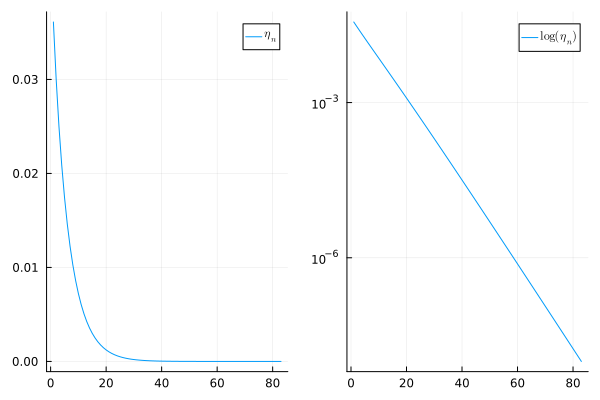

In [39]:
pl1 = plot(result.history; label="\$\\eta_n\$")
pl2 = plot(result.history; yaxis=:log, label="\$\\log(\\eta_n)\$")
plot(pl1, pl2)

__Define two linear operators `L_S(U::Union{Vector, Matrix}, X_0::Matrix, m::PerturbedModel)::Matrix` and `L_T(U::Matrix, X_0::Matrix, m::PerturbedModel)::Matrix` which implement the derivatives of the simulation and the time-iteration operator respectively.__



In [99]:
# simulation operator

function L_S(U, X_0, M)
    (;A,B,C,D,E,F) = M
    P = E + F*X_0
    return P*U
end


function L_T(U, X_0, M)
    (;A,B,C,D,E,F) = M
    M1 = ((B+(C+D*X_0)*F))
    return M1 \ ( D * U * (E + F*X_0) )
end

L_T (generic function with 1 method)

In [100]:
# check that the functions work:

Δs =  ss.s*0.01 
L_S( ss.s*0.01, result.X, m)

2-element Vector{Float64}:
 0.0
 0.027099672004969193

In [95]:
result.X

1×2 Matrix{Float64}:
 0.768674  0.0278097

In [101]:
# check that the functions work:

L_T(  result.X, result.X, m)

1×2 Matrix{Float64}:
 -0.63523  -0.0229819

__Implement a function `spectral_radius(f::Function)::Float64` which implements the power iteration method to compute the biggest eigenvalues of the two previously defined operators. Check that Blanchard-Kahn conditions are met.__

Note that in the code above, we have defined L_S as a function mapping a vector to another one and L_T as a function mapping a matrix to another matrix.
Howver spectral_radius function should work in both cases.

In [144]:
function spectral_radius(f, el; K=1000, verbose=true, τ_η=1e-5)
    # only the type of el is used: it is to define an initial guess of the right type
    x0 = rand(size(el)...)
    @show (x0)
    # then x0 has the same shape as el (a vector or a matrix)
    u0 = x0 ./ norm(x0)
    λ0 = 1.0
    for i=1:K
        x1 = f(u0)
        λ = norm(x1)
        if verbose
            @show (i, λ)
        end
        η = abs(λ-λ0)
        if η<τ_η
            return λ
        end
        λ0 = λ
        u0 = x1/λ
    end
end

spectral_radius (generic function with 1 method)

In [145]:
spectral_radius(u->L_S(u, result.X, m ), ss.s) 

x0 = [0.25230154361551804, 0.6038357713367117]
(i, λ) = (1, 1.2035344682960807)
(i, λ) = (2, 1.1399455826120903)
(i, λ) = (3, 1.097702137167803)
(i, λ) = (4, 1.068246955608944)
(i, λ) = (5, 1.0467360946644375)
(i, λ) = (6, 1.0304157660831001)
(i, λ) = (7, 1.0176458682821379)
(i, λ) = (8, 1.007400734175485)
(i, λ) = (9, 0.9990103174295336)
(i, λ) = (10, 0.9920200964229645)
(i, λ) = (11, 0.9861116464817636)
(i, λ) = (12, 0.9810556257776433)
(i, λ) = (13, 0.9766828542653095)
(i, λ) = (14, 0.9728659065426654)
(i, λ) = (15, 0.9695070391530314)
(i, λ) = (16, 0.9665300592680999)
(i, λ) = (17, 0.9638747172486893)
(i, λ) = (18, 0.9614927574241215)
(i, λ) = (19, 0.9593450837269429)
(i, λ) = (20, 0.9573996905766055)
(i, λ) = (21, 0.9556301289816819)
(i, λ) = (22, 0.9540143534034359)
(i, λ) = (23, 0.9525338437331563)
(i, λ) = (24, 0.9511729288899947)
(i, λ) = (25, 0.9499182601160274)
(i, λ) = (26, 0.9487583967581851)
(i, λ) = (27, 0.9476834775177361)
(i, λ) = (28, 0.9466849573078967)
(i, λ) = (29,

0.9281235019830123

The eigenvalue associated with the backward operator is <1:  the solution is non explosive.

In [147]:
spectral_radius(u->L_T(u, result.X, m ), result.X) 

x0 = [0.9223850429219426 0.7401971838456877]
(i, λ) = (1, 1.1738132635171477)
(i, λ) = (2, 1.084267593148263)
(i, λ) = (3, 1.0233551852317575)
(i, λ) = (4, 0.98315077400919)
(i, λ) = (5, 0.9553542939869155)
(i, λ) = (6, 0.9352025258333201)
(i, λ) = (7, 0.9200036616450014)
(i, λ) = (8, 0.908168052407606)
(i, λ) = (9, 0.8987095045123624)
(i, λ) = (10, 0.8909882450978713)
(i, λ) = (11, 0.8845728811970118)
(i, λ) = (12, 0.8791627387670785)
(i, λ) = (13, 0.8745422153647037)
(i, λ) = (14, 0.8705528739585885)
(i, λ) = (15, 0.8670757789074741)
(i, λ) = (16, 0.8640199666376337)
(i, λ) = (17, 0.8613147135566195)
(i, λ) = (18, 0.8589042242488865)
(i, λ) = (19, 0.856743903215621)
(i, λ) = (20, 0.8547976872877922)
(i, λ) = (21, 0.8530361036433727)
(i, λ) = (22, 0.851434833766086)
(i, λ) = (23, 0.8499736363381633)
(i, λ) = (24, 0.8486355288185263)
(i, λ) = (25, 0.847406158161558)
(i, λ) = (26, 0.8462733116673858)
(i, λ) = (27, 0.8452265329238237)
(i, λ) = (28, 0.8442568174516205)
(i, λ) = (29, 0.843

0.8267154306834951

In [ ]:
The eigenvalue associated with the backward operator is also smaller than 1: expectations are well defined.

The two conditions backward and forward are met: the model satisfies the Blanchard-Kahn conditions.

__Write a function `simulate(s0::Vector, X::Matrix, p, T::Int64)::Tuple{Matrix, Matrix}` to simulate the model over $T$ periods (by using the formula $\Delta s_t = (E + F X) \Delta s_{t-1}$. Return a matrix for the states (one line per date) and another matrix for the controls. Bonus: add a keyword option to compute variables levels or log-deviations. If possible, return a DataFrame object.__

In [206]:
function simulate(s0::Vector, X::Matrix, p, T::Int64)
    sim_s = Vector{Float64}[] # values for the states (vector of vectors)
    sim_x = Vector{Float64}[] # values for the controls (vector of vectors)
    (;E, F) = p
    P = E + F*X # transition matrix
    for t=1:T
        s = P*s0
        # we compute the corresponding control
        x = X*s
        # and save the results
        push!(sim_s, s)
        push!(sim_x, x)

        s0 = s

    end
    # now we can reformat the results as two matrices
    mat_s = cat((e' for e in sim_s)...;dims=1)
    mat_x = cat((e' for e in sim_x)...;dims=1)

    # copy not strictly necessary (just to realign the data)
    return (mat_s,mat_x)

end

simulate (generic function with 1 method)

In [207]:
# take an initial 1% productivity shock
Δs0 = [0.01, 0.0]
sim_s, sim_x = simulate(Δs0, result.X, m, 100)

([0.009000000000000001 0.007686740027830092; 0.008100000000000001 0.014049898188954277; … ; 2.951266543065285e-7 0.00015779309682694114; 2.6561398887587566e-7 0.00014662882621801013], [0.007131832163907194; 0.006616983250375311; … ; 4.615039073763088e-6; 4.28187814142107e-6;;])

__Make some nice plots.__

In [208]:
sim_s

100×2 Matrix{Float64}:
 0.009       0.00768674
 0.0081      0.0140499
 0.00729     0.0192619
 0.006561    0.023475
 0.0059049   0.0268236
 0.00531441  0.0294261
 0.00478297  0.0313869
 0.00430467  0.0327976
 0.0038742   0.0337388
 0.00348678  0.0342812
 ⋮           
 6.17037e-7  0.000263337
 5.55333e-7  0.000244801
 4.998e-7    0.000227556
 4.4982e-7   0.000211513
 4.04838e-7  0.000196589
 3.64354e-7  0.000182709
 3.27919e-7  0.000169799
 2.95127e-7  0.000157793
 2.65614e-7  0.000146629

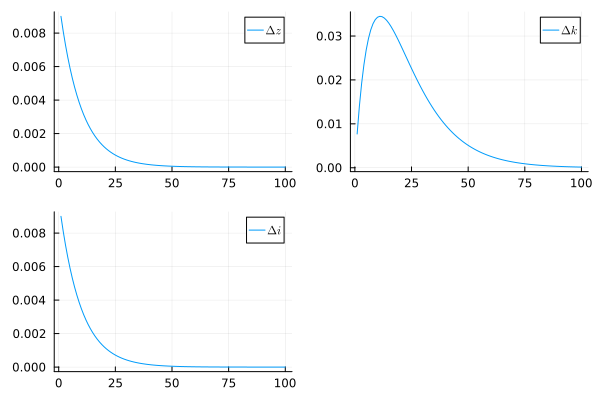

In [213]:
pl1 = plot(sim_s[:,1]; label="\$\\Delta z\$")
pl2 = plot(sim_s[:,2]; label="\$\\Delta k\$")
pl3 = plot(sim_s[:,1]; label="\$\\Delta i\$")
plot(pl1, pl2, pl3)